## Exploration 11. Stock Price Prediction📊📈

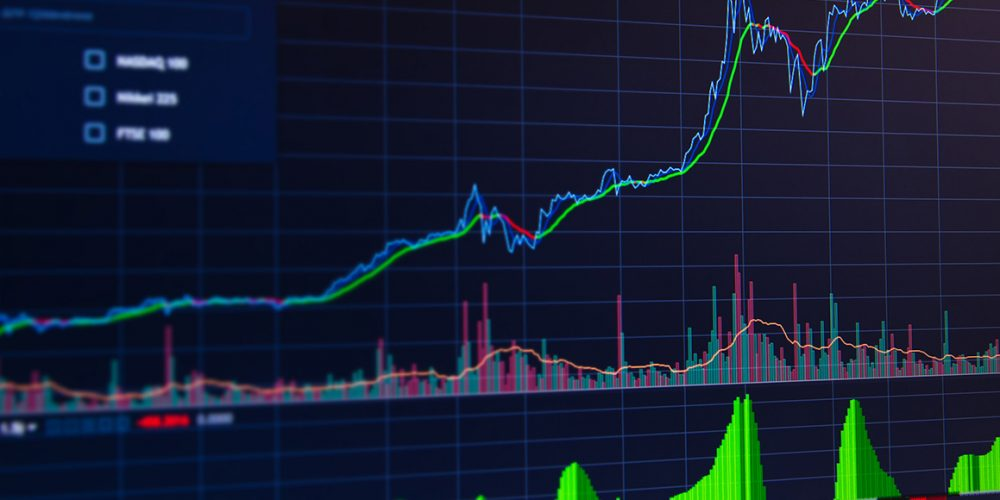

### Table of Content

### 1. Introduction

* 1.1 What is White Noise?
* 1.2 How to explain SARIMAX Results?
* 1.3 What is AR, MA?

### 2. Import Libraries

### 3. Defining Functions

* 3.1 Qualitative Graph Analysis
* 3.2 Quantitative Augmented Dicky-Fuller Test
* 3.3 Time Series Decomposition
* 3.4 ACF, PACF Graph
* 3.5 1st order differencing
* 3.6 2nd order differencing
* 3.7 Train and Test Data Split
* 3.8 Prediction Graph
* 3.9 Calculate the Result
* 3.10 Grid Search

### 4. Several Companies Stock Forecast

* 4.1 Johnson&Johnson
* 4.2 Pfizer
* 4.3 Novartis

### 5. Learn More

* 5.1 Using Auto Arima

### 6. Retrospection

***

### 1. Introduction

### 1.1 What is White Noise?

* 백색잡음(White Noise)
  * 백색잡음(Withe Noise)란 패턴이 남아있지 않고 무작위로 야기되는 잡음
  * 백색잡음(White Noise)은 2가지 속성을 만족해야 하며 하나라도 만족하지 못하면 모델이 개선의 여지가 있음을 의미함
    * 잔차들은 정규분포이며, 평균 0과 일정한 분산을 가져야 함
    * 잔차들이 시간의 흐름에 따라 상관성이 없어야 함
* 시계열 예측 모델이 실제 현상의 트렌드와 주기를 잘 반영할수록 잔차의 변동이 작아지고 이를 바탕으로 모델 개선 여부를 파악
* 잔차 진단의 결과는 주로 시각화로 확인이 가능하며 추세 및 주기 중 어떤 것을 건드려야할지 의사결정이 됨

### 1.2 How to explain SARIMAX Results

* Ljung-Box(L1)
  * 잔차가 white noise를 따르는지 판단하는 테스트 
  * 귀무가설: 잔차가 white noise를 따른다
  * `p-value`가 낮으면 잔차가 white noise를 따르지 않고 시간대 별 잔차가 corrleated 되어 있는 것으로 판단

* Jarque-Bera 
  * 귀무가설 : 잔차가 normal distribution을 따른다
  * `p-value`가 낮으면 잔차가 normal distribution을 따르지 않는다고 판단

### 1.3 What is AR, MA?

||AR(p)|MA(q)|해석|
|:---:|:---:|:---:|:---:|
|ACF|점차적으로 감소|사차 q 이후에 0|시계열 데이터가 **AR의 특성**을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소|
|PACF|시차 p 이후에 0|점차적으로 감소|시계열 데이터가 **MA의 특성**을 띄는 경우, ACF는 급격히 감소하고 PACF는 천천히 감소|

### 2. Import Libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 3. Defining Functions

### 3.1 Qualitative Graph Analysis

In [2]:
# 정성적 그래프 분석 
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

### 3.2 Quantitative Augmented Dicky-Fuller Test

In [3]:
# 정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### 3.3 Time Series Decomposition

In [4]:
#시계열 분해 (Time Series Decomposition)

def time_series_decomposition_residual(timeseries, model='multiplicative', period = 30):
    decomposition = seasonal_decompose(timeseries, model='multiplicative', period = 30) 
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

### 3.4 ACF, PACF Graph

In [5]:
# ACF, PACF 그려보기 -> p,q 구하기

def acf_pacf(timeseries):
    plot_acf(timeseries)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(timeseries)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

### 3.5 1st order differencing

In [6]:
# 1차 차분 구하기

def diff1(timeseries):
    diff_1 = timeseries.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

### 3.6 2nd order differencing

In [7]:
# 혹시 필요한 경우 2차 차분 구하기

def diff2(timeseries):
    diff_1 = timeseries.diff(periods=1).iloc[1:]
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)

### 3.7 Train and Test Data Split

In [8]:
def data_split(timeseries, ts_log):
    train_data, test_data = timeseries[:int(len(ts_log)*0.9)], timeseries[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    return train_data, test_data

### 3.8 Prediction Graph

In [9]:
def forecast(train, test, fitted_m):
    fc = fitted_m.forecast(len(test), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc

### 3.9 Calculate the Result

In [10]:
def result(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

### 3.10 Grid Search

In [11]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q))

                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)),
                                         columns=['order', 'AIC'])
                result_df.sort_values(sort, inplace=True)

    return result_df

### 4. Several Companies Stock Forecast

### 4.1 Johnson&Johnson(JNJ)

### 4.1.1 Prepare Time Series Data

In [12]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/JNJ.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_jnj = df['Close']

ts_jnj.head()

Date
2021-02-10    166.809998
2021-02-11    166.059998
2021-02-12    166.580002
2021-02-16    165.070007
2021-02-17    165.660004
Name: Close, dtype: float64

* 읽어 들인 데이터 파일은 Pandas를 통해 2개의 컬럼을 가진 DataFrame으로 변환
* DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성

### 4.1.2 Perform Various Pre-processing

#### ● Missing value handling

In [13]:
# 결측치 처리
ts_jnj = ts_jnj.interpolate(method='time')
ts_jnj[ts_jnj.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

#### ● Log transformation

In [14]:
# 로그 변환 시도 
ts_jnj_log = np.log(ts_jnj)

### 4.1.3 Time Series Stationary Analysis

#### ● Qualitative graph analysis

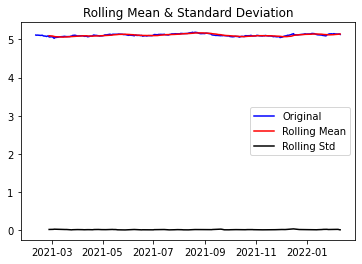

In [15]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_jnj_log, window=12)

* 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해보았다.
* 시각화한 결과만 놓고 보면 이 시계열 데이터는 안정적이라고 볼 수 있다. 
* 명확하게 단정짓기 위해 좀 더 통계적으로 접근해본다. 

#### ● Quantitative Augmented Dicky-Fuller Test

In [16]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_jnj_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.473007
p-value                          0.122181
#Lags Used                       2.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


* `p-value`의 값이 1보다는 작으나, 귀무가설을 기각(p-value<0.05)할 수 있는 수치는 아니다. 
* 따라서, 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없다.
* 시계열 분해(Time series decomposition) 기법을 적용하여 데이터를 Stationary하게 만들어 준다.

#### ● Time Series Decomposition & Residual Stability check

Results of Dickey-Fuller Test:
Test Statistic                -5.838078e+00
p-value                        3.834453e-07
#Lags Used                     3.000000e+00
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


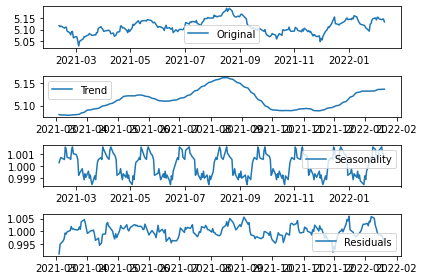

In [17]:
time_series_decomposition_residual(ts_jnj_log)

* `Decomposing`을 통해 얻어진 `Residual`은 압도적으로 낮은 `p-value`를 보여준다. 
* 이 정도 수치라면 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다. 

### 4.1.4 Create Training and Test Datasets

#### ● split train, test data set

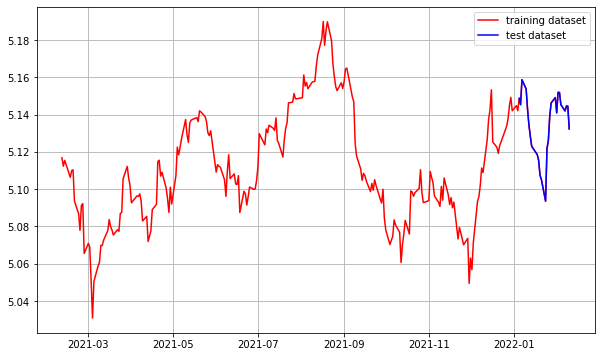

In [18]:
train_data_jnj, test_data_jnj = data_split(ts_jnj_log, ts_jnj_log)

### 4.1.5 Finding Titration ARIMA Parameters

#### ● Draw ACF, PACF -> find p,q

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


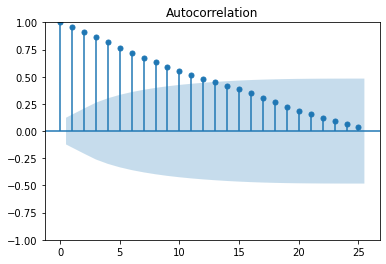

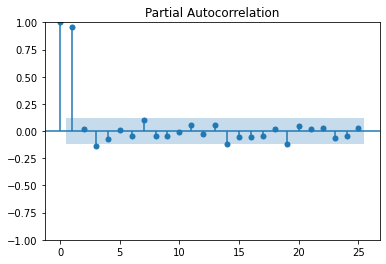

In [19]:
acf_pacf(ts_jnj_log)

* 위 데이터는 `AR`의 특성을 띈다고 볼 수 있다.
* `PACF` 그래프를 볼 때 `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있기 때문에 `p=1`이 적합해보인다.
* 반면 `ACF`는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태를 보이며 차수 25에서 거의 0에 수렴한다.
* 따라서, `p`와 `q`는 (1, 25), (1, 0)을 고려해 볼 수 있다.
* 하지만 모형의 식별에서  `p`, `q` 간결의 원칙으로 인해 `p` <3 , `q` < 3으로 선택하는 것이 가장 좋다.
* 최종적으로 `p`와 `q`는 (1, 0)으로 결정한다.

#### ● Check differencing stability -> find d

Results of Dickey-Fuller Test:
Test Statistic                -1.026366e+01
p-value                        4.173147e-18
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


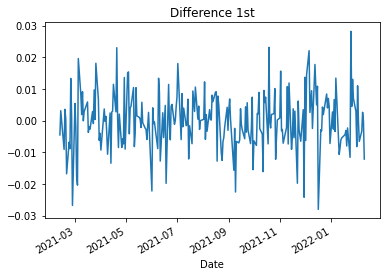

In [20]:
# 1차 차분
diff1(ts_jnj_log)

* 1차 차분을 구했을 때 안정화된 상태인 것을 확인할 수 있다.
* 따라서, `d`는 1로 둔다.

Results of Dickey-Fuller Test:
Test Statistic                -8.228880e+00
p-value                        6.139450e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


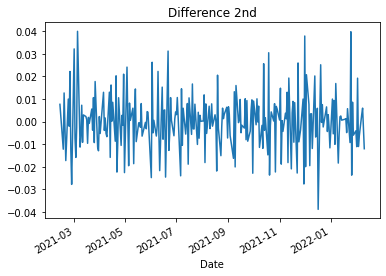

In [21]:
# 2차 차분
diff2(ts_jnj_log)

### 4.1.6 ARIMA Model Training and Test

#### ● Build ARIMA Model & Fit

In [22]:
# Build Model
model_jnj = ARIMA(train_data_jnj, order=(1, 1, 0)) # order는 (p, d, q) 순서
fitted_m_jnj = model_jnj.fit() 

print(fitted_m_jnj.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 754.564
Date:                Thu, 17 Feb 2022   AIC                          -1505.128
Time:                        10:45:35   BIC                          -1498.278
Sample:                             0   HQIC                         -1502.364
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0575      0.066     -0.877      0.380      -0.186       0.071
sigma2      7.584e-05   6.05e-06     12.538      0.000     6.4e-05    8.77e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


* `P>|z|` 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값이다. 
* `ar.L1`의 `P>|z|` 값이 0.380으로 0.05보다 크게 확인되어 학습이 적정성이 떨어진다 볼 수 있다.
* `Jarque-Bera (JB)`의 `P`값이 0.05보다 작아 귀무가설(잔차가 normal distribution을 따른다)을 기각해버린다.
* 이는 잔차가 정규분포를 따르지 않는다는 것을 의미한다. 
* 잔차의 그래프를 그려 확인해본다.

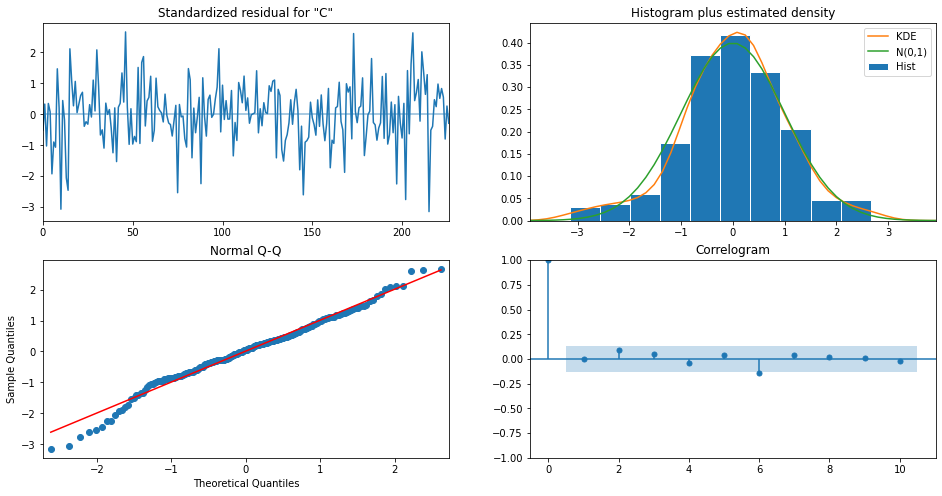

In [23]:
fitted_m_jnj.plot_diagnostics(figsize=(16, 8))
plt.show()

* 확실하게 정규분포를 따른다고 할 수는 없을 것 같다.
* 높은 `ar.L1`의 `P>|z|` 값이 확인되므로 2차 차분을 진행한 값을 사용한다.
* 위에서 설정했던 `d`를 2로 변경한다.
* 최종 결정 p, d, q : (1, 2, 0)

In [24]:
# Build Model
model_jnj2 = ARIMA(train_data_jnj, order=(1, 2, 0)) # order는 (p, d, q) 순서
fitted_m_jnj2 = model_jnj2.fit() 

print(fitted_m_jnj2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 709.585
Date:                Thu, 17 Feb 2022   AIC                          -1415.170
Time:                        10:45:36   BIC                          -1408.329
Sample:                             0   HQIC                         -1412.409
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5675      0.055    -10.342      0.000      -0.675      -0.460
sigma2         0.0001   8.45e-06     12.956      0.000    9.29e-05       0.000
Ljung-Box (L1) (Q):                   8.86   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

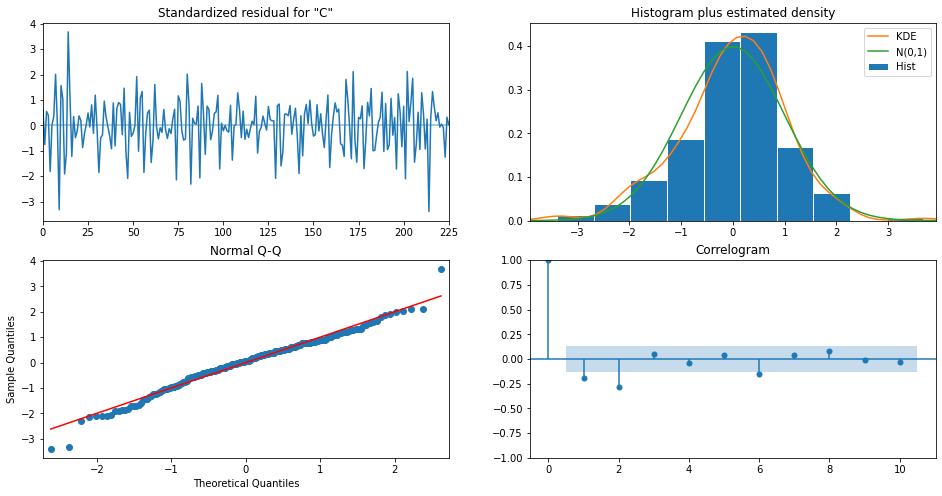

In [25]:
fitted_m_jnj2.plot_diagnostics(figsize=(16, 8))
plt.show()

#### ● Model test & plotting

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


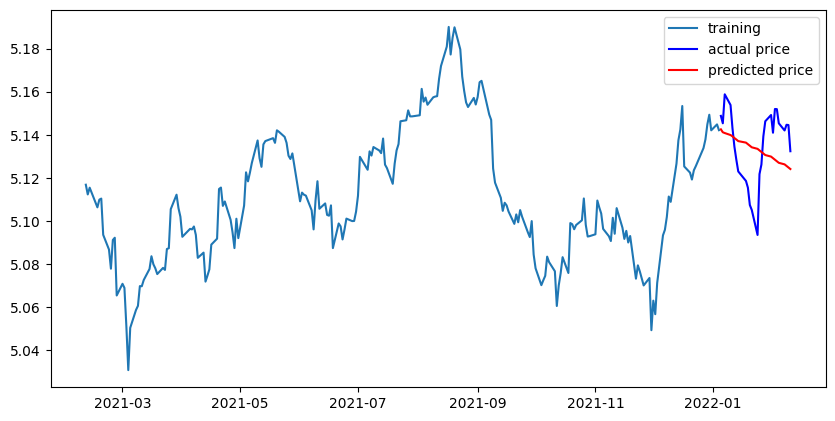

In [26]:
fc_jnj2 = forecast(train_data_jnj, test_data_jnj, fitted_m_jnj2)

In [27]:
result(test_data_jnj, fc_jnj2)

MSE:  9.120777587367611
MAE:  2.6578083338164378
RMSE:  3.02006251381782
MAPE: 1.57%


### 4.2 Pfizer

### 4.2.1 Prepare Time Series Data

In [28]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/PFE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_Pfe = df['Close']

ts_Pfe.head()

Date
2021-02-10    34.740002
2021-02-11    34.430000
2021-02-12    34.720001
2021-02-16    34.689999
2021-02-17    34.889999
Name: Close, dtype: float64

* 읽어 들인 데이터 파일은 Pandas를 통해 2개의 컬럼을 가진 DataFrame으로 변환
* DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성

### 4.2.2 Perform Various Pre-processing

#### ● Missing value handling

In [29]:
# 결측치 처리
ts_Pfe = ts_Pfe.interpolate(method='time')
ts_Pfe[ts_Pfe.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

#### ● Log transformation

In [30]:
# 로그 변환 시도 
ts_log_Pfe = np.log(ts_Pfe)

### 4.2.3 Time Series Stationary Analysis

#### ● Qualitative graph analysis

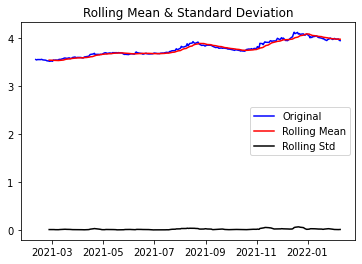

In [31]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_Pfe, window=12)

* 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해보았다.
* 시각화한 결과만 놓고 봤을 때 평균이 약간씩 증가하는 추이가 확인된다. 
* 따라서, 이 시계열 데이터는 적어도 안정적이진 않다고 정성적인 결론을 내릴 수 있을 것 같다.
* 명확하게 단정짓기 위해 좀 더 통계적으로 접근해본다.

#### ● Quantitative Augmented Dicky-Fuller Test

In [32]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_Pfe)

Results of Dickey-Fuller Test:
Test Statistic                  -1.806224
p-value                          0.377376
#Lags Used                      13.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


* 이 시계열의 경우 `p-value`가 0.3773으로 확인된다.
* `시계열 데이터가 안정적이지 않다.`는 귀무가설을 기각할 수 없게 되므로 이 시계열이 안정적인 시계열이라고 말할 수는 없다. 

#### ● Time Series Decomposition & Residual Stability check

Results of Dickey-Fuller Test:
Test Statistic                  -3.356481
p-value                          0.012535
#Lags Used                      12.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


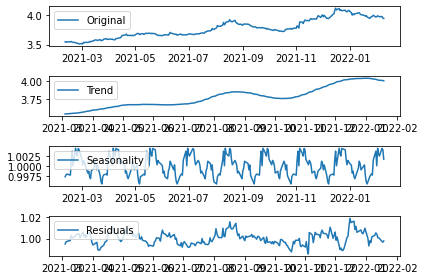

In [33]:
time_series_decomposition_residual(ts_log_Pfe)

* 시계열 데이터를 decomposing시켜준 후 residual을 확인했다.
* `p-value`가 0.012로 귀무가설을 기각할 수 있는 수준으로 낮아진 것을 확인할 수 있다.

### 4.2.4 Create Training and Test Datasets

#### ● split train, test data set

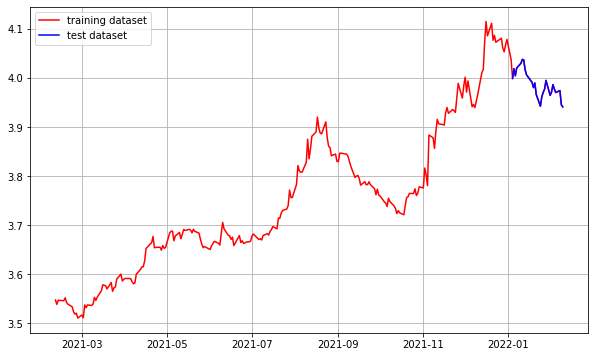

In [34]:
train_data_Pfe, test_data_Pfe = data_split(ts_log_Pfe, ts_log_Pfe)

### 4.2.5 Finding Titration ARIMA Parameters

#### ● Draw ACF, PACF -> find p,q

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


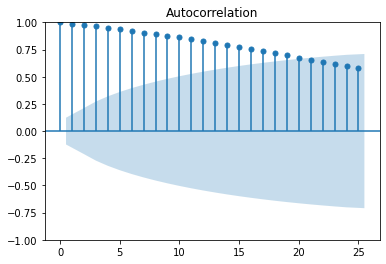

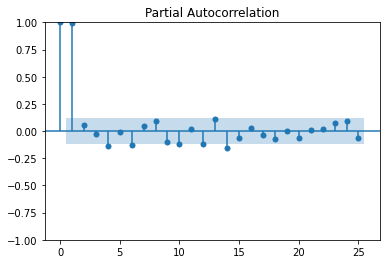

In [35]:
acf_pacf(ts_log_Pfe)

* 위 데이터는 `AR`의 특성을 띈다고 볼 수 있다.
* `PACF` 그래프를 볼 때 `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있기 때문에 `p=1`이 적합해보인다.
* 반면 `ACF`는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태를 보인다.
* 따라서, `p`와 `q`는 (1, 0)으로 결정한다.

#### ● Check differencing stability -> find d

Results of Dickey-Fuller Test:
Test Statistic                  -3.287571
p-value                          0.015443
#Lags Used                      12.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


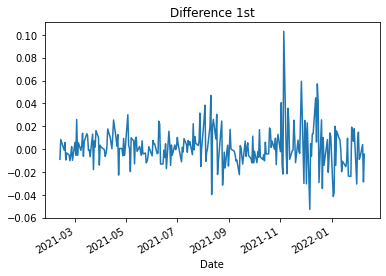

In [36]:
# 1차 차분
diff1(ts_log_Pfe)

* 1차 차분의 그래프를 확인했을 때 어느정도 안정적인 상태라고 볼 수 있을 것 같다. 
* 일단 `d`를 1로 먼저 진행해보며 이후 과정을 진행하며 변경을 고려해본다.
* 2차 차분도 진행해본다.

Results of Dickey-Fuller Test:
Test Statistic                -7.894077e+00
p-value                        4.357986e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


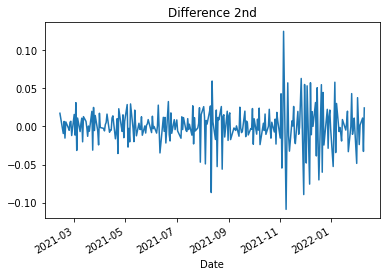

In [37]:
# 2차 차분
diff2(ts_log_Pfe)

* 최종결정 p, d, q : (1, 1, 0), (1, 2, 0)

### 4.2.6 ARIMA Model Training and Test

#### ● Build ARIMA Model & Fit

In [38]:
# Build Model
model_2 = ARIMA(train_data_Pfe, order=(1, 1, 0)) # order는 (p, d, q) 순서
fitted_m_Pfe2 = model_2.fit() 

print(fitted_m_Pfe2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 600.110
Date:                Thu, 17 Feb 2022   AIC                          -1196.220
Time:                        10:45:38   BIC                          -1189.379
Sample:                             0   HQIC                         -1193.459
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1495      0.053     -2.841      0.005      -0.253      -0.046
sigma2         0.0003   1.39e-05     20.835      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.16   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


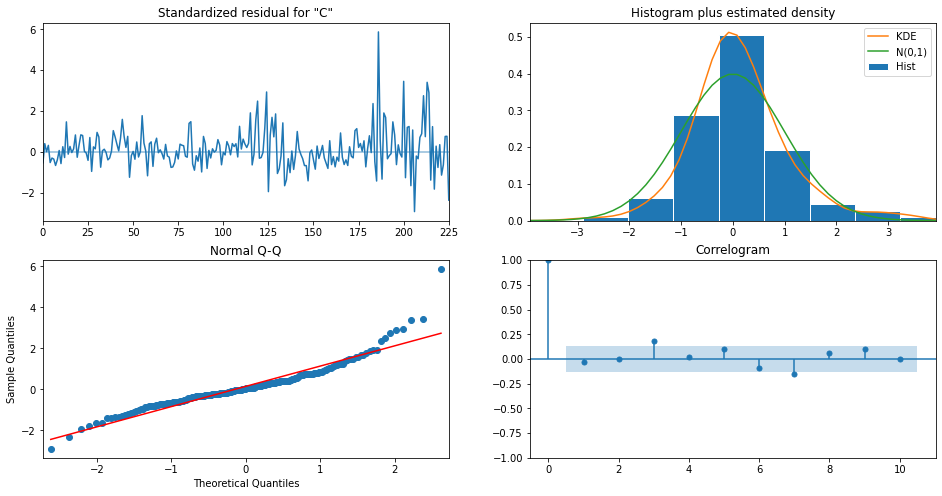

In [39]:
fitted_m_Pfe2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [40]:
# Build Model
model_3 = ARIMA(train_data_Pfe, order=(1, 2, 0)) # order는 (p, d, q) 순서
fitted_m_Pfe3 = model_3.fit() 

print(fitted_m_Pfe3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 545.574
Date:                Thu, 17 Feb 2022   AIC                          -1087.148
Time:                        10:45:39   BIC                          -1080.315
Sample:                             0   HQIC                         -1084.390
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5694      0.037    -15.563      0.000      -0.641      -0.498
sigma2         0.0005   2.22e-05     20.627      0.000       0.000       0.001
Ljung-Box (L1) (Q):                  17.37   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


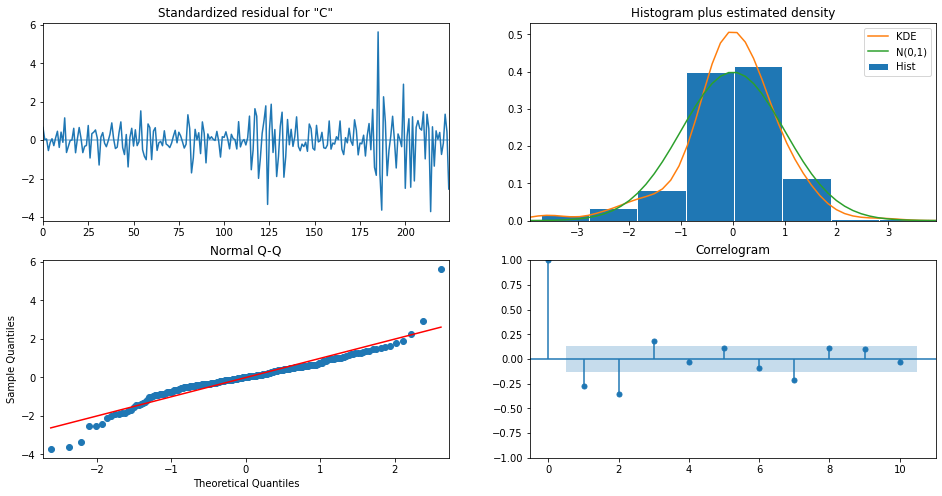

In [41]:
fitted_m_Pfe3.plot_diagnostics(figsize=(16, 8))
plt.show()

*  p, d, q가 각각 (1, 1, 0), (1, 2, 0)일 때를 확인했을 때 두 모델에서 모두 `ar.L1`의 `P>|z|`값이 적절하게 나왔다.
* (1, 2, 0)에서 잔차 백색소음을 따르지 않는 것을 확인하였다. 
* 따라서 예측은 (1, 1, 0)으로 진행한다.

#### ● Model test & plotting

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


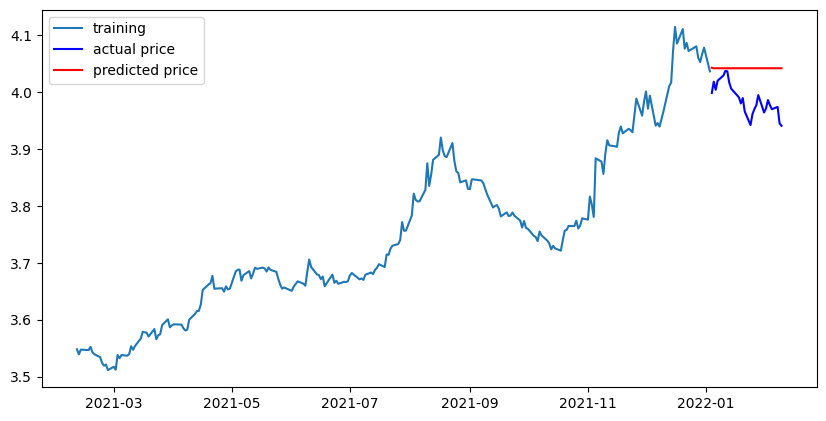

In [42]:
fc_Pfe = forecast(train_data_Pfe, test_data_Pfe, fitted_m_Pfe2)

#### ● Measure the final predictive model accuracy

In [43]:
result(test_data_Pfe, fc_Pfe)

MSE:  11.286243887176614
MAE:  3.0175990577353478
RMSE:  3.359500541327031
MAPE: 5.67%


### 4.3 Novartis

### 4.3.1 Prepare Time Series Data

In [44]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_Nov = df['Close']

ts_Nov.head()

Date
2021-02-11    92.190002
2021-02-12    92.029999
2021-02-16    91.459999
2021-02-17    90.089996
2021-02-18    89.389999
Name: Close, dtype: float64

* 읽어 들인 데이터 파일은 Pandas를 통해 2개의 컬럼을 가진 DataFrame으로 변환
* DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성

### 4.1.2 Perform Various Pre-processing

#### ● Missing value handling

In [45]:
# 결측치 처리
ts_Nov = ts_Nov.interpolate(method='time')
ts_Nov[ts_Nov.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

#### ● Log transformation

In [46]:
# 로그 변환 시도 
ts_log_Nov = np.log(ts_Nov)

### 4.2.3 Time Series Stationary Analysis

#### ● Qualitative graph analysis

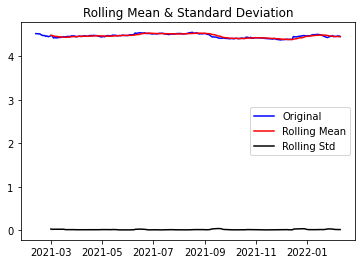

In [47]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_Nov, window=12)

* 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해보았다.
* 시각화한 결과만 놓고 보면 이 시계열 데이터는 안정적이라고 볼 수 있다. 
* 명확하게 단정짓기 위해 좀 더 통계적으로 접근해본다. 

#### ● Quantitative Augmented Dicky-Fuller Test

In [48]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_Nov)

Results of Dickey-Fuller Test:
Test Statistic                  -1.943573
p-value                          0.311849
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


* 이 시계열의 경우 `p-value`가 0.3118으로 확인된다.
* `시계열 데이터가 안정적이지 않다.`는 귀무가설을 기각할 수 없게 되므로 이 시계열이 안정적인 시계열이라고 말할 수는 없다. 

#### ● Time Series Decomposition & Residual Stability check

Results of Dickey-Fuller Test:
Test Statistic                  -4.391158
p-value                          0.000308
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


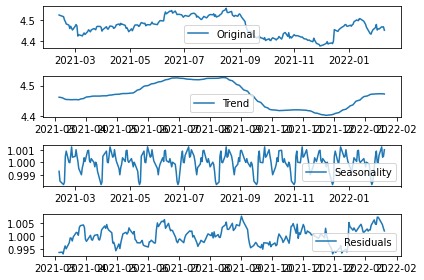

In [49]:
time_series_decomposition_residual(ts_log_Nov)

* 시계열 데이터를 decomposing시켜준 후 residual을 확인했다.
* `p-value`가 0.003로 귀무가설을 기각할 수 있는 수준으로 낮아진 것을 확인할 수 있다.

### 4.2.4 Create Training and Test Datasets

#### ● split train, test data set

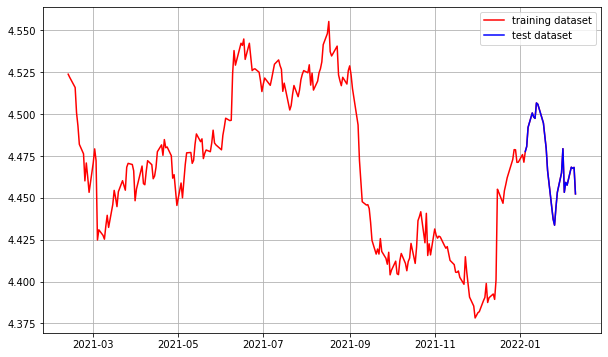

In [50]:
train_data_Nov, test_data_Nov = data_split(ts_log_Nov, ts_log_Nov)

### 4.2.5 Finding Titration ARIMA Parameters

#### ● Draw ACF, PACF -> find p,q

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


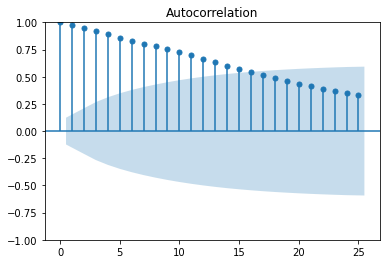

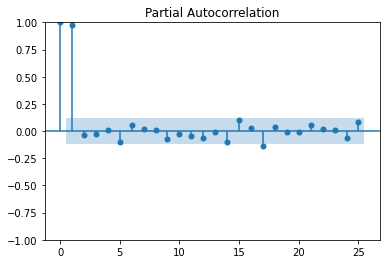

In [51]:
acf_pacf(ts_log_Nov)

* 위 데이터는 `AR`의 특성을 띈다고 볼 수 있다.
* `PACF` 그래프를 볼 때 `p`가 2 이상인 구간에서 `PACF`는 거의 0에 가까워지고 있기 때문에 `p=1`이 적합해보인다.
* 반면 `ACF`는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태를 보인다.
* 따라서, `p`와 `q`는 (1, 0)으로 결정한다.

#### ● Check differencing stability -> find d

Results of Dickey-Fuller Test:
Test Statistic                -1.511111e+01
p-value                        7.694027e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


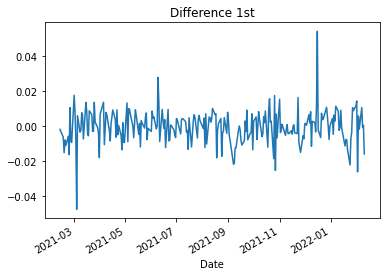

In [52]:
diff1(ts_log_Nov)

* 1차 차분의 그래프를 확인했을 때 어느정도 안정적인 상태라고 볼 수 있을 것 같다. 
* 일단 `d`를 1로 먼저 진행해보며 이후 과정을 진행하며 변경을 고려해본다.
* 2차 차분도 진행해본다.

Results of Dickey-Fuller Test:
Test Statistic                -7.083032e+00
p-value                        4.613598e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


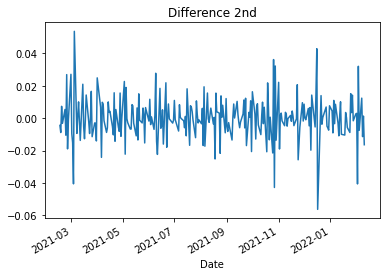

In [53]:
diff2(ts_log_Nov)

* 최종결정 p, d, q : (1, 1, 0)

### 4.2.6 ARIMA Model Training and Test

#### ● Build ARIMA Model & Fit

In [54]:
# Build Model
model_4 = ARIMA(train_data_Nov, order=(1, 1, 0)) # order는 (p, d, q) 순서
fitted_m_Nov1 = model_4.fit() 

print(fitted_m_Nov1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 734.478
Date:                Thu, 17 Feb 2022   AIC                          -1464.956
Time:                        10:45:41   BIC                          -1458.115
Sample:                             0   HQIC                         -1462.196
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0155      0.067      0.230      0.818      -0.117       0.147
sigma2      8.799e-05   4.38e-06     20.078      0.000    7.94e-05    9.66e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


* `P>|z|` 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값이다.
* `ar.L1`의 `P>|z`| 값이 0.818으로 0.05보다 크게 확인되어 학습이 적정성이 떨어진다 볼 수 있다.
* `Jarque-Bera (JB)`의 P값이 0.05보다 작아 귀무가설(잔차가 normal distribution을 따른다)을 기각해버린다.
* 이는 잔차가 정규분포를 따르지 않는다는 것을 의미한다.
* 잔차의 그래프를 그려 확인해본다.

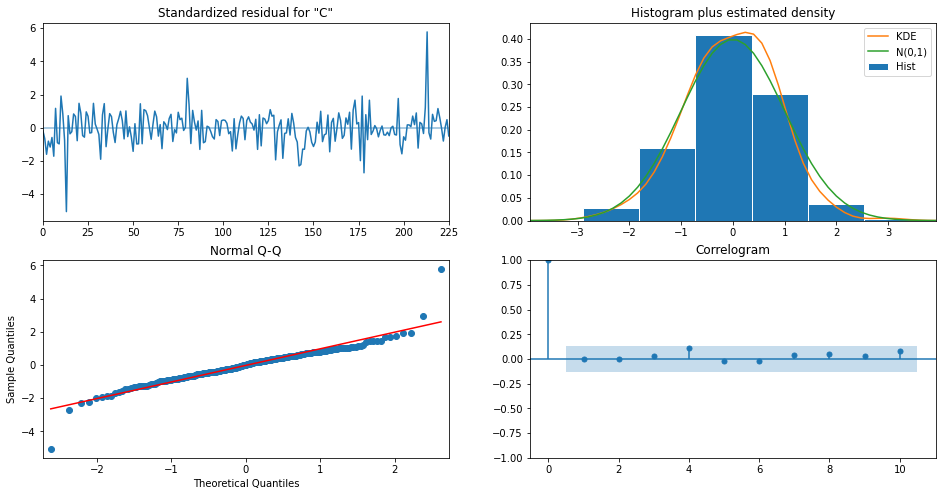

In [55]:
fitted_m_Nov1.plot_diagnostics(figsize=(16, 8))
plt.show()

* 확실하게 정규분포를 따른다고 할 수는 없을 것 같다.
* 높은 `ar.L1`의 `P>|z|` 값이 확인되므로 2차 차분을 진행한 값을 사용한다.

In [56]:
# Build Model
model_5 = ARIMA(train_data_Nov, order=(1, 2, 0)) # order는 (p, d, q) 순서
fitted_m_Nov2 = model_5.fit() 

print(fitted_m_Nov2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 685.798
Date:                Thu, 17 Feb 2022   AIC                          -1367.597
Time:                        10:45:42   BIC                          -1360.765
Sample:                             0   HQIC                         -1364.839
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4939      0.037    -13.372      0.000      -0.566      -0.421
sigma2         0.0001   8.15e-06     16.139      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   6.77   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


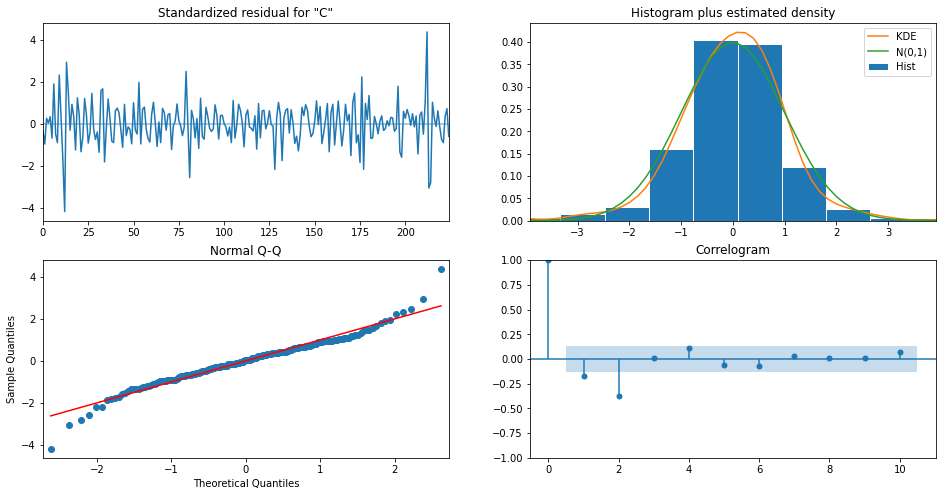

In [57]:
fitted_m_Nov2.plot_diagnostics(figsize=(16, 8))
plt.show()

* 위에서 설정했던 `d`를 2로 변경했을 때 잔차의 정규성과 백색 잡음을 따르지 않는 것을 확인할 수 있다.
* `d`를 0으로 두고 `q`를 1로 둬본다.

In [58]:
# Build Model
model_6 = ARIMA(train_data_Nov, order=(1, 0, 0)) # order는 (p, d, q) 순서
fitted_m_Nov3 = model_6.fit() 

print(fitted_m_Nov3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 737.487
Date:                Thu, 17 Feb 2022   AIC                          -1468.975
Time:                        10:45:43   BIC                          -1458.700
Sample:                             0   HQIC                         -1464.829
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4756      0.022    205.773      0.000       4.433       4.518
ar.L1          0.9757      0.015     65.692      0.000       0.947       1.005
sigma2      8.697e-05   4.41e-06     19.718      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


* `P>|z|` 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값이다.
* `ar.L1`, `const`의 `P>|z`| 값이 0.05보다 작게 확인되어 학습이 적절하다 볼 수 있다.
* `Jarque-Bera (JB)`의 P값이 0.05보다 작아 귀무가설(잔차가 normal distribution을 따른다)을 기각해버린다.
* 이는 잔차가 정규분포를 따르지 않는다는 것을 의미한다.
* 잔차의 그래프를 그려 확인해본다.

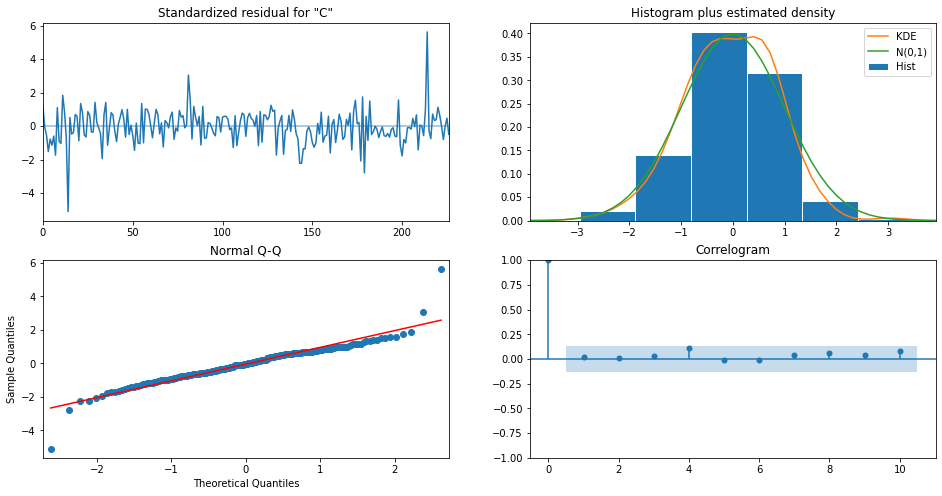

In [59]:
fitted_m_Nov3.plot_diagnostics(figsize=(16, 8))
plt.show()

* 잔차가 정규분포를 따르지 않으나 백색잡음을 따르고 있으므로
* 예측을 진행해 볼 수 있을 것 같다.
* 따라서 p,q,d를 (1, 0, 0)로 두고 예측을 진행해본다.

#### ● Model test & plotting

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


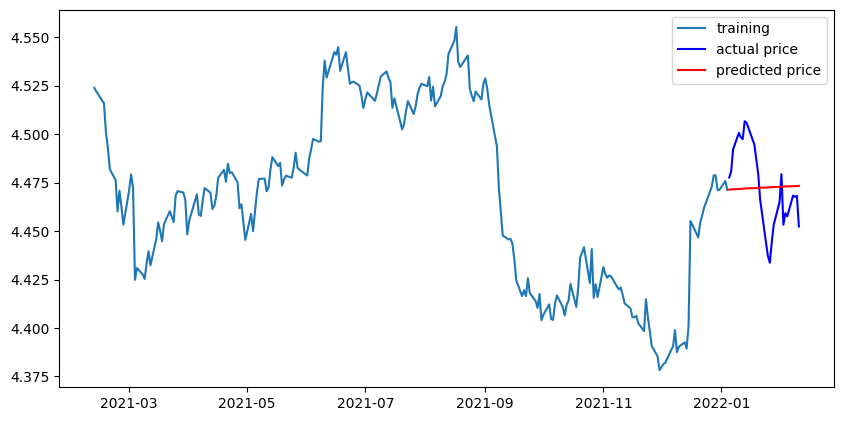

In [60]:
fc_Nov = forecast(train_data_Nov, test_data_Nov, fitted_m_Nov3)

#### ● Measure the final predictive model accuracy

In [61]:
result(test_data_Nov, fc_Nov)

MSE:  3.5654928318610053
MAE:  1.638010115730431
RMSE:  1.88825126290465
MAPE: 1.87%


### 5. Learn More

### 5.1 Using Auto Arima

* AIC값을 기준으로 AIC가 가장 낮은 값일 때의 p, d, q를 구해본다.
* for문을 이용해서 모든 경우의 수를 이용하여서 생성하고 AIC 값을 이용해서 최적의 모형을 찾아주는 방법이다.

### 5.1.1 Johnson&Johnson

In [62]:
my_auto_arima(train_data_jnj, [3, 3, 3])

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

,order,AIC
9,p1 d0 q0,-1511.819913
11,p1 d0 q2,-1510.905804
18,p2 d0 q0,-1510.129781
10,p1 d0 q1,-1510.125469
20,p2 d0 q2,-1509.741904
19,p2 d0 q1,-1507.875333
3,p0 d1 q0,-1506.378094
12,p1 d1 q0,-1505.128160
4,p0 d1 q1,-1505.006634
5,p0 d1 q2,-1504.981003


In [74]:
# Build Model
model_7 = ARIMA(train_data_jnj, order=(1, 0, 0)) # order는 (p, d, q) 순서
fitted_m_jnj3 = model_7.fit() 

print(fitted_m_jnj3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 758.910
Date:                Thu, 17 Feb 2022   AIC                          -1511.820
Time:                        10:46:35   BIC                          -1501.532
Sample:                             0   HQIC                         -1507.669
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1140      0.015    332.311      0.000       5.084       5.144
ar.L1          0.9603      0.017     56.013      0.000       0.927       0.994
sigma2      7.431e-05   6.04e-06     12.301      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


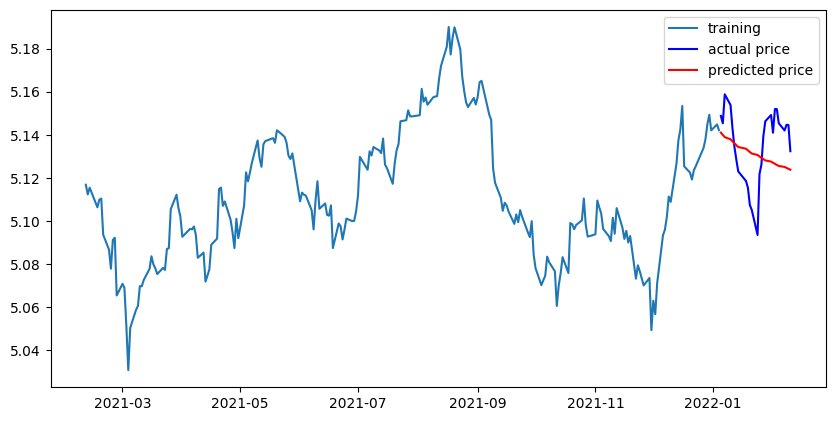

In [75]:
fc_jnj3 = forecast(train_data_jnj, test_data_jnj, fitted_m_jnj3)

In [65]:
result(test_data_jnj, fc_jnj3)

MSE:  9.151548541614433
MAE:  2.2103318445112397
RMSE:  3.0251526476550623
MAPE: 1.32%


### 5.1.2 Pfizer

In [66]:
my_auto_arima(train_data_Pfe, [3, 3, 3])

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,order,AIC
23,p2 d1 q2,-1214.885364
14,p1 d1 q2,-1199.492942
12,p1 d1 q0,-1196.220240
4,p0 d1 q1,-1195.926282
20,p2 d0 q2,-1195.383862
5,p0 d1 q2,-1195.081952
21,p2 d1 q0,-1194.249492
13,p1 d1 q1,-1194.185198
3,p0 d1 q0,-1193.264494
22,p2 d1 q1,-1192.223077


In [67]:
# Build Model
model_8 = ARIMA(train_data_Pfe, order=(2, 1, 2)) # order는 (p, d, q) 순서
fitted_m_Pfe3 = model_8.fit() 

print(fitted_m_Pfe3.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 612.443
Date:                Thu, 17 Feb 2022   AIC                          -1214.885
Time:                        10:45:50   BIC                          -1197.783
Sample:                             0   HQIC                         -1207.983
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6444      0.059     10.902      0.000       0.529       0.760
ar.L2         -0.7402      0.059    -12.448      0.000      -0.857      -0.624
ma.L1         -0.8702      0.031    -28.408      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


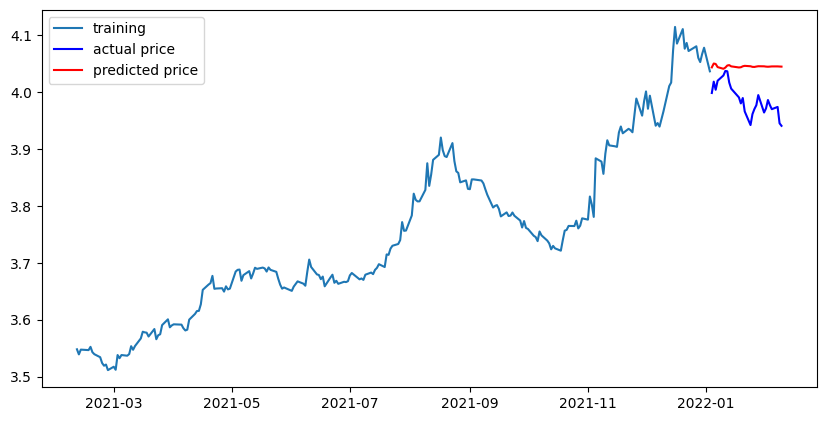

In [68]:
fc_Pfe3 = forecast(train_data_Pfe, test_data_Pfe, fitted_m_Pfe3)

In [69]:
result(test_data_Pfe, fc_Pfe3)

MSE:  12.403226465665675
MAE:  3.198603066432791
RMSE:  3.5218214698740304
MAPE: 6.01%


### 5.1.3 Novartis

In [80]:
my_auto_arima(train_data_Nov, [3, 3, 3])

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequenc

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

,order,AIC
9,p1 d0 q0,-1468.974826
10,p1 d0 q1,-1467.137361
18,p2 d0 q0,-1467.127652
3,p0 d1 q0,-1466.902364
19,p2 d0 q1,-1465.566370
11,p1 d0 q2,-1465.149710
12,p1 d1 q0,-1464.956331
4,p0 d1 q1,-1464.950009
20,p2 d0 q2,-1463.490688
13,p1 d1 q1,-1463.004752


In [81]:
# Build Model
model_9 = ARIMA(train_data_Nov, order=(1, 0, 0)) # order는 (p, d, q) 순서
fitted_m_Nov4 = model_9.fit() 

print(fitted_m_Nov4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 737.487
Date:                Thu, 17 Feb 2022   AIC                          -1468.975
Time:                        10:48:19   BIC                          -1458.700
Sample:                             0   HQIC                         -1464.829
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4756      0.022    205.773      0.000       4.433       4.518
ar.L1          0.9757      0.015     65.692      0.000       0.947       1.005
sigma2      8.697e-05   4.41e-06     19.718      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


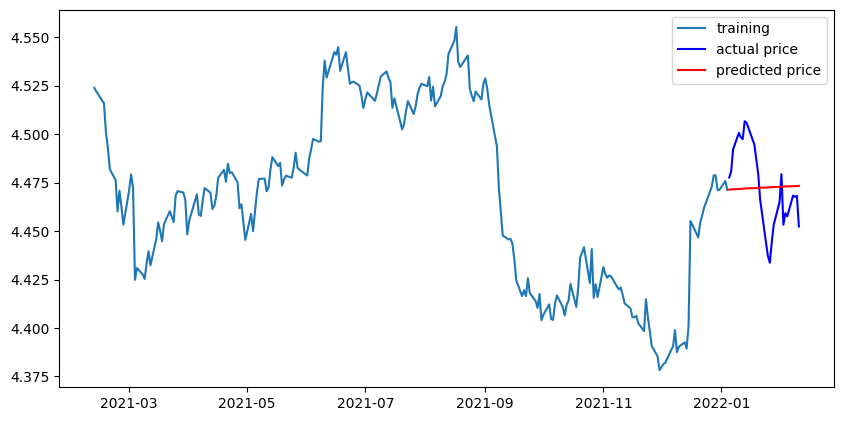

In [82]:
fc_Nov4 = forecast(train_data_Nov, test_data_Nov, fitted_m_Nov4)

In [83]:
result(test_data_Nov, fc_Nov4)

MSE:  3.5654928318610053
MAE:  1.638010115730431
RMSE:  1.88825126290465
MAPE: 1.87%


### 6. Retrospection

### 6.1 What was difficult

* 통계적인 내용이 너무 많아 힘들었다.
* 통계를 잘 알았으면 더 나은 분석을 해볼 수 있었을 것 같은데, 아쉬웠다.

### 6.2 What I found out

* 백색잡음
* SARIMAX Results 해석방법
* 모델 fit 이후 잔차 분석하는 방법
* AIC를 이용한 최적 모델 찾기

### 6.3 What I want to know more about

* 예측선이 x축과 평행하게 나타나는 경우들이 보였다.
* 타당한 근거로 결정된 모수들로 예측을 진행했음에도 불구하고 결과가 단순 직선이 나왔다는 것은 여전히 개선이 필요한 사항이라 판단했다.
  (내가 원했던 식의 예측 결과가 아니였으므로🤔)
* 부분에 대해 개선을 진행해보았다. (Attachment1, 2 참조)
* 위와 같은 문제가 나타나는 이유에 대해서는 완벽히 이해하지는 못했다.
* 그러나 이해한 부분까지 정리해보자면
  * 모델이 예측을 진행함에 있어서 적절한 AR과 MA의 찾기 어려운 경우 (0, d, 0)
  * 전달된 모수가 최적의 모델을 만들어 내지 못했을 때 (p, 0, q)
  * 최적의 모델로 학습된 경우 잔차는 정규분포와 백색잡음을 따라야 한다.
  * AIC값으로만 최적의 모델을 찾는 방법은 적절하지 않을 수도...
  * 결론적으로는 해당 모델이 예측을 잘 못하고 있다!
* 개선 방법 : 한번에 테스트 데이터를 예측하는 것이 아니라, 한 스텝씩 예측하고, 테스트 데이터를 관측”할 때마다 모형을 업데이트해주는 REFRESH 전략을 쓰자!
* 예측선이 x축과 수평으로 나타나는 문제를 개선해 보았다. (Attachments참조)
* 예측선이 실제 값과 거의 비슷하게 나타나는 것을 확인할 수 있었다.
* 이 문제에 대해 완벽히 이해하지는 못 했다.공부가 더 필요할 것 같다. 😂

### 6.4 Self-Resolution

* 데이터 분석에 통계는 떼려야 뗄 수 없는 관계인 듯하다.
* 통계도 공부해야 하는 건가
* 왜이리 할게 많지?

#### [Attachments] 

* Attachment1.Pfizer_OneStepPrediction.ipynb
* Attachment2.Novartis_OneStepPrediction.ipynb

#### [References]

1. 백색잡음
* https://today-1.tistory.com/30
2. SARIMAX Results
* https://hongl.tistory.com/99
3. 예측이 x축과 수평으로 나오는 이유, 잔차분석
* https://stats.stackexchange.com/questions/529827/python-auto-arima-predicts-constant-value
* https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/
4. 최적 모델 찾기
* https://bluemumin.github.io/adp/2021/03/10/ADP-20%ED%9A%8C-ADP-%EC%8B%A4%EA%B8%B0-python-%ED%86%B5%EA%B3%84%EB%B6%84%EC%84%9D(Arima,-%EC%9E%94%EC%B0%A8%EB%B6%84%EC%84%9D)/